In [8]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [79]:
l = lambda x: torch.log(1+torch.exp(-x))


## Simple case

In [13]:
z1 = torch.tensor([0,1], dtype=torch.float32)
z2 = torch.tensor([0,0], dtype=torch.float32)
z3 = torch.tensor([1,0], dtype=torch.float32)
z4 = torch.tensor([1,1], dtype=torch.float32)

# pz1 = 1/8
# pz2 = 4/17
# pz3 = 3/5
# pz4 = 1-pz1-pz2-pz3

# assert(pz4 > 0)
# print("pz4:", pz4)

A = torch.randn(2, 2, requires_grad=True)

pz4: 0.039705882352941146


In [15]:
def loss_fun(A = A, z1 = z1, z2 = z2, z3 = z3, z4 = z4, p = [1/8, 4/17, 3/5, 1-1/8-4/17-3/5]):
    pz1, pz2, pz3, pz4 = p
    res = l(z1.matmul(A).matmul(z1-z2))*pz1*pz2 + l(z1.matmul(A).matmul(z1-z3))*pz1*pz3 + l(z1.matmul(A).matmul(z1-z4))*pz1*pz4 \
    + l(z2.matmul(A).matmul(z2-z1))*pz1*pz2 + z2.matmul(A).matmul(z2-z3)*pz2*pz3 + z2.matmul(A).matmul(z2-z4)*pz2*pz4 \
    + l(z3.matmul(A).matmul(z3-z1))*pz1*pz3 + l(z3.matmul(A).matmul(z3-z2))*pz2*pz3 + l(z3.matmul(A).matmul(z3-z4))*pz3*pz4 \
    + l(z4.matmul(A).matmul(z4-z1))*pz1*pz4 + l(z4.matmul(A).matmul(z4-z2))*pz2*pz4 + l(z4.matmul(A).matmul(z4-z3))*pz3*pz4
    return res

def display(A, loss_fun, verbose = True):
    # identity matrix loss
    print("identity matrix loss: ", loss_fun(A = torch.eye(A.shape[0])).item())
    # solved A loss
    print("solved A loss: ",loss_fun(A = A).item())
    # Spec norm 
    U, S, Vh = torch.linalg.svd(A, full_matrices=False)
    if verbose:
        print("Singular values: ",S)
    else:
        print("Spec norm: ",S[0])
    # F norm not bounded
    fnorm = torch.square(A).sum().item()
    print("Frobenius norm square: ", fnorm)
    if verbose:
        print("A is: ", A)

non-constrain

In [24]:
p = [0,0,1/2,1/2]
# p = [1/8, 4/17, 3/5, 1-1/8-4/17-3/5]
A = torch.randn(2, 2, requires_grad=True)

In [18]:
learning_rate = 1e-3
epoch_loss = []
for t in range(20001):
    loss = loss_fun(A = A, p = p)
    if t % 5000 == 0:
        print(t, loss.item())
    
    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()
    
    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        A -= learning_rate * A.grad
    
    # Zero the gradients before running the backward pass.
    A.grad.zero_()

    epoch_loss.append(loss.item())

0 0.15124627947807312
5000 0.13122914731502533
10000 0.11749076098203659
15000 0.10687927901744843
20000 0.09814735502004623


In [20]:
display(A, loss_fun)

identity matrix loss:  0.15097177028656006
solved A loss:  0.19531668722629547
Singular values:  tensor([3.5297, 0.7195], grad_fn=<LinalgSvdBackward0>)
Frobenius norm:  3.6023383140563965
A is:  tensor([[-0.3326, -1.2470],
        [-1.1985,  3.1424]], requires_grad=True)


frobenius norm bound by 2

In [29]:
p = [0,0,1/2,1/2]
# p = [1/8, 4/17, 3/5, 1-1/8-4/17-3/5]
A = torch.randn(2, 2, requires_grad=True)

In [35]:
learning_rate = 5e-4
epoch_loss = []
for t in range(20001):
    loss = loss_fun(A = A, p = p)
    if t % 5000 == 0:
        print(t, loss.item())
    
    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()
    
    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        A -= learning_rate * A.grad
    
    fnorm = torch.sqrt(torch.square(A).sum()/2).item()

    if fnorm > 1:
        with torch.no_grad():
            A /= fnorm
    
    # Zero the gradients before running the backward pass.
    A.grad.zero_()

    epoch_loss.append(loss.item())

0 0.211614191532135
5000 0.2110370546579361
10000 0.2106093466281891
15000 0.21028831601142883
20000 0.21004554629325867


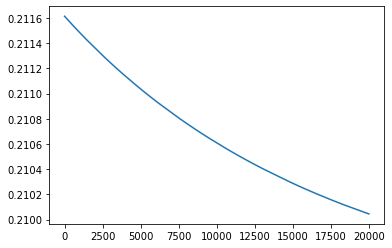

In [36]:
# sns.lineplot(epoch_loss)

In [37]:
display(A, loss_fun)

identity matrix loss:  0.15097177028656006
solved A loss:  0.19324398040771484
Singular values:  tensor([1.4050, 0.1609], grad_fn=<LinalgSvdBackward0>)
Frobenius norm:  2.000000476837158
A is:  tensor([[ 0.1678, -0.4419],
        [ 0.0054,  1.3329]], requires_grad=True)


Spectral norm bounded by 1

In [38]:
p = [0,0,1/2,1/2]
# p = [1/8, 4/17, 3/5, 1-1/8-4/17-3/5]
A = torch.randn(2, 2, requires_grad=True)

In [54]:
learning_rate = 1e-5
def train_specNorm(learning_rate= 1e-5, A = A, p = p):
    epoch_loss = []
    for t in range(20001):
        loss = loss_fun(A = A, p = p)
        if t % 5000 == 0:
            print(f"Epoch: {t}/{20000}  === Train Cost:{loss.item()}")
        
        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()
        
        # Update the weights using gradient descent. Each parameter is a Tensor, so
        # we can access its gradients like we did before.
        with torch.no_grad():
            A -= learning_rate * A.grad
        
        U, S, Vh = torch.linalg.svd(A, full_matrices=False)

        if S[0].item() > 1:
            with torch.no_grad():
                A /= S[0].item()
        
        # Zero the gradients before running the backward pass.
        A.grad.zero_()

        epoch_loss.append(loss.item())
    return A, epoch_loss
    
A, epoch_loss = train_specNorm(learning_rate= learning_rate, A = A, p = p)

0 0.4841488003730774
5000 0.4823833703994751
10000 0.48062771558761597
15000 0.47888171672821045
20000 0.47714537382125854


In [55]:
# sns.lineplot(epoch_loss)

In [56]:
display(A, loss_fun)

identity matrix loss:  0.15097177028656006
solved A loss:  0.4324134588241577
Singular values:  tensor([0.8887, 0.5710], grad_fn=<LinalgSvdBackward0>)
Frobenius norm:  1.1159248352050781
A is:  tensor([[-0.6015, -0.0354],
        [-0.1586, -0.8531]], requires_grad=True)


## High Dimension

In [104]:
def loss_fun(A, z1, z2):
    res = l(z1.matmul(A).matmul(z1-z2)) + l(z2.matmul(A).matmul(z2-z1))
    return res

def display(A, z1, z2, verbose = True):
    # identity matrix loss
    print("identity matrix loss: ", loss_fun(A = torch.eye(A.shape[0]), z1 = z1, z2 = z2).item())
    # solved A loss
    print("solved A loss: ",loss_fun(A = A, z1 = z1, z2 = z2).item())
    # Spec norm 
    U, S, Vh = torch.linalg.svd(A, full_matrices=False)
    if verbose:
        print("Singular values: ",S)
    else:
        print("Spec norm: ",S[0])
    # F norm not bounded
    fnorm = torch.square(A).sum().item()
    print("Frobenius norm square: ", fnorm)
    if verbose:
        print("A is: ", A)

In [81]:
# dim of z
k = 100
p1, p2 = 1/4,3/4
l = lambda x: torch.log(1+torch.exp(-x))

In [82]:
# generate size k array with each entry =  1 w.p.  p1 
#                                          0 w.p.  p2
def sampleZ(k=100,p = [1/4,3/4]):
    p1, p2 = p
    tmp = np.random.choice([0,1], k, p = [p1,p2])
    z = torch.from_numpy(tmp).type(torch.float32)
    return z

z1 = sampleZ()
z2 = sampleZ()
# print(z1-z2)

In [83]:
class myModel(nn.Module):
    def __init__(self,k) -> None:
        super(myModel, self).__init__()

        self.M = nn.Linear(k,k, bias=False)

    def forward(self, z1, z2):
        """
        Input:
            z1: first image latent vector
            z2: second image latent vector
        Output:
            loss
        """
        Mz1 = self.M(z1)
        Mz2 = self.M(z2)
        loss = l(Mz1.matmul(Mz1-Mz2)) + l(Mz2.matmul(Mz2-Mz1))
        return loss

model = myModel(k)
# We want to investigate whether A = M^T M is closed to identity
print(model.M)

model(z1,z2)

Linear(in_features=100, out_features=100, bias=False)


tensor(0.0183, grad_fn=<AddBackward0>)

In [84]:
def train(model, train_optimizer, constrain = ["fnorm", "spec_norm"]):
    """
    epoch: each epoch represents we sampled one pair (z1, z2) from \eta
    """
    model.train()
    z1 = sampleZ()
    z2 = sampleZ()
    loss = model(z1,z2)

    train_optimizer.zero_grad()
    loss.backward()
    train_optimizer.step()

    M = model.M.weight
    A = M.T.matmul(M)
    k = M.shape[0]
    if constrain == "fnorm":
        fnorm = torch.sqrt(torch.square(A).sum()/k).item()
        if fnorm > 1:
            with torch.no_grad():
                for param in model.parameters():
                    param /= fnorm.item()

    elif constrain == "spec_norm":
        U, S, Vh = torch.linalg.svd(A, full_matrices=False)

        if S[0].item() > 1:
            with torch.no_grad():
                for param in model.parameters():
                    param /= torch.sqrt(S[0]).item()
    
    
    return loss
    

In [85]:
# test
# train(model, optimizer, 10)

In [86]:
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0
MOMENTUM = 0

Non-constrain

In [ ]:
model = myModel(k)
# We want to investigate whether A = M^T M is closed to identity
print(model.M)

model(z1,z2)

In [116]:
# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)


# training loop
train_loss_total = []
for epoch in range(20001):
    train_loss = train(model, optimizer, constrain = None)
    train_loss_total.append(train_loss)
    # LOGGING
    if epoch % 5000 == 0:
        print("Epoch: {}/{}  === Train Cost: {}".format(epoch + 1, 20000, train_loss))

    # save model
    # torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict(),}, args.results_dir + '/model_last.pth')

Epoch: 1/20000  === Train Cost: 0.003970321733504534
Epoch: 5001/20000  === Train Cost: 0.005510072223842144
Epoch: 10001/20000  === Train Cost: 0.0004606905858963728
Epoch: 15001/20000  === Train Cost: 0.05881146714091301
Epoch: 20001/20000  === Train Cost: 0.0024756579659879208


In [117]:
M = model.M.weight
A = M.T.matmul(M)

In [118]:
z1 = sampleZ()
z2 = sampleZ()

In [119]:
display(A,z1 = z1, z2 = z2, verbose=False)


identity matrix loss:  0.0
solved A loss:  0.003224327927455306
Spec norm:  tensor(1.3389, grad_fn=<SelectBackward0>)
Frobenius norm square:  22.94900894165039


In [120]:
# the same
# model(z1,z2)
# l(z1.matmul(A).matmul(z1-z2)) + l(z2.matmul(A).matmul(z2-z1))
# loss_fun(A = A, z1=z1, z2=z2)

fnorm constrain

In [121]:
model = myModel(k)
# We want to investigate whether A = M^T M is closed to identity
print(model.M)

model(z1,z2)

Linear(in_features=100, out_features=100, bias=False)


tensor(0.0071, grad_fn=<AddBackward0>)

In [122]:
# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)


# training loop
train_loss_total = []
for epoch in range(20001):
    train_loss = train(model, optimizer, constrain = "fnorm")
    train_loss_total.append(train_loss)
    # LOGGING
    if epoch % 5000 == 0:
        print("Epoch: {}/{}  === Train Cost: {}".format(epoch + 1, 20000, train_loss))

    # save model
    # torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict(),}, args.results_dir + '/model_last.pth')

Epoch: 1/20000  === Train Cost: 0.010331184603273869
Epoch: 5001/20000  === Train Cost: 0.005885259248316288
Epoch: 10001/20000  === Train Cost: 0.010167139582335949
Epoch: 15001/20000  === Train Cost: 0.03847473859786987
Epoch: 20001/20000  === Train Cost: 0.0041666459292173386


In [123]:
M = model.M.weight

In [124]:
A = M.T.matmul(M)

In [127]:
z1 = sampleZ()
z2 = sampleZ()

In [130]:
display(A, z1, z2, verbose=False)

identity matrix loss:  1.1920928244535389e-07
solved A loss:  0.01049877516925335
Spec norm:  tensor(1.2870, grad_fn=<SelectBackward0>)
Frobenius norm square:  22.531206130981445


In [279]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

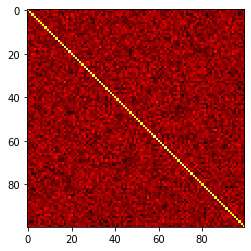

In [132]:
plt.imshow(A.detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()


In [134]:
A[:5,:5]

tensor([[ 3.0977e-01, -4.4899e-02,  8.5455e-04, -1.6953e-02, -6.0697e-02],
        [-4.4899e-02,  3.3429e-01,  1.0946e-02, -4.1330e-05,  4.3079e-03],
        [ 8.5455e-04,  1.0946e-02,  3.5772e-01,  1.7699e-02, -3.4041e-03],
        [-1.6953e-02, -4.1330e-05,  1.7699e-02,  3.2811e-01, -6.4591e-02],
        [-6.0697e-02,  4.3079e-03, -3.4041e-03, -6.4591e-02,  3.2046e-01]],
       grad_fn=<SliceBackward0>)

Spec_norm constrain

In [135]:
model = myModel(k)
# We want to investigate whether A = M^T M is closed to identity
print(model.M)

model(z1,z2)

Linear(in_features=100, out_features=100, bias=False)


tensor(0.0039, grad_fn=<AddBackward0>)

In [136]:
# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)


# training loop
train_loss_total = []
for epoch in range(20001):
    train_loss = train(model, optimizer, constrain = "spec_norm")
    train_loss_total.append(train_loss)
    # LOGGING
    if epoch % 5000 == 0:
        print("Epoch: {}/{}  === Train Cost: {}".format(epoch + 1, 20000, train_loss))

    # save model
    # torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict(),}, args.results_dir + '/model_last.pth')

Epoch: 1/20000  === Train Cost: 0.0020099999383091927
Epoch: 5001/20000  === Train Cost: 0.024358335882425308
Epoch: 10001/20000  === Train Cost: 0.01584814116358757
Epoch: 15001/20000  === Train Cost: 0.010305714793503284
Epoch: 20001/20000  === Train Cost: 0.04692508280277252


In [137]:
M = model.M.weight
A = M.T.matmul(M)

In [138]:
z1 = sampleZ()
z2 = sampleZ()

In [139]:
display(A, z1, z2, verbose=False)

identity matrix loss:  6.198863957251888e-06
solved A loss:  0.09437490999698639
Spec norm:  tensor(1.0000, grad_fn=<SelectBackward0>)
Frobenius norm square:  13.600052833557129


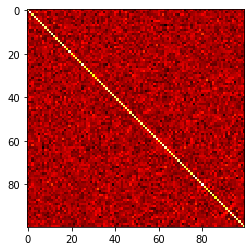

In [140]:
plt.imshow(A.detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

In [141]:
A[:5,:5]

tensor([[ 0.2743, -0.0199, -0.0072,  0.0190, -0.0277],
        [-0.0199,  0.3172,  0.0068,  0.0340,  0.0914],
        [-0.0072,  0.0068,  0.2513, -0.0301, -0.0297],
        [ 0.0190,  0.0340, -0.0301,  0.2748,  0.0301],
        [-0.0277,  0.0914, -0.0297,  0.0301,  0.2921]],
       grad_fn=<SliceBackward0>)

In [143]:
torch.square(A).sum().item()

13.600052833557129